### Setup

In [1]:
# Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import norm
import dataframe_image as dfi

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
prompt_palette = {'short': '#bad7f5', 'medium': '#73afeb', 'long': '#004f9e', 'average':'gray'}

model_name_transformer = {'wizardcoder': 'WiCo',
                          'gpt-35-turbo': 'GPT35T',
                          'gpt-4-turbo': 'GPT4T',
                          'codellama': 'CLLam',
                          'opencodeinterpreter': 'OpCoInt',
                          'magicoder': 'MaCo',
                          'deepseeker-coder': 'DeSeCo',
                          'codex':'CoX',
                          'gemini': 'GeMi',
                          'baseline': 'Base'
                          }


colors = ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6", 'grey']

model_color_mapper = dict(zip(model_name_transformer.values(), colors))


# Data loading and preprocessing

In [3]:
# Load sheet
load_sheet = lambda x: pd.read_excel('results.xlsx', sheet_name=x)

attention = load_sheet('attention')
convolution = load_sheet('convolution')
pca = load_sheet('pca')

In [4]:
# metrics
security_metrics = ['security_low', 'warnings', 'errors']
reliability_metrics = ['errors', 'warnings','complexity_to_methods','halstead_bugs','cpu']
#reliability_metrics = ['errors', 'warnings','max_complexity','halstead_bugs','cpu']
efficiency_metrics = ['cpu', 'memory_usage']
#maintainability_metrics = ['mi','refactor','convention','comments_to_loc','sloc', 'halstead_effort']
maintainability_metrics = ['mi','refactor','convention','comments_to_loc','sloc','sloc_to_methods', 'halstead_effort']

In [5]:
def dataframe_preprocessing(df0):
    # Copy the dataframe
    df = df0.copy()

    # Values with 0 values in any of the columns other than model and prompt with 0.01
    zerozero_one = ['errors', 'warnings', 'refactor', 'convention', 'pylint_score', 'halstead_bugs', 'security_low']# Standardize the columns

    # LOC normalization is also applied here as it is the same metrics
    for col in zerozero_one:
        df[col] = df[col].apply(lambda x: 0.01 if x == 0 else x)

        if col != "security_low":
            df[col] = df[col] / df['loc']


    # Method normalization
    method_norms = ['max_complexity', 'sloc']

    for col in method_norms:
        if col == "max_complexity":
            col_out = "complexity_to_methods"
        elif col == 'mi':
            col_out = "maintainability_index_to_methods"
        else:
            col_out = "sloc_to_methods"
        df[f'{col_out}'] = df[col] / df['number_of_methods']
        df[f'{col_out}'] = df[f'{col_out}'] / max(df[f'{col_out}'])

    # Divide by maximum
    max_norms = zerozero_one + ['complexity_to_methods', 'comments_to_loc', 'sloc_to_methods', 'memory_usage']
    for col in max_norms:
        df[col] = df[col] / max(df[col])


    # Colummns with natural scales
    cols_natural_scale = {
        'mi': 100,
        'pylint_score': 10,
        'cpu':100}

    for col, scale in cols_natural_scale.items():
        df[col] = df[col] / scale

    # Inverse columns
    inverse = ['errors', 'cpu', 'warnings', 'refactor', 'convention', 'halstead_bugs', 'security_high', 'security_low', 'security_medium', 'memory_usage', 'complexity_to_methods']
    for col in inverse:
        if df[col].sum() == len(df):
            continue
        df[col] = 1 - df[col]

    # Replacing model names with shorter names
    df['model'] = df['model'].apply(lambda x: model_name_transformer[x])

    return df



In [6]:
# metrics
security_metrics = ['security_low', 'warnings', 'errors']
reliability_metrics = ['errors', 'warnings','complexity_to_methods','halstead_bugs','cpu']
#reliability_metrics = ['errors', 'warnings','max_complexity','halstead_bugs','cpu']
efficiency_metrics = ['cpu', 'memory_usage']
#maintainability_metrics = ['mi','refactor','convention','comments_to_loc','sloc', 'halstead_effort']
maintainability_metrics = ['mi','refactor','convention','comments_to_loc','sloc','sloc_to_methods', 'halstead_effort']

In [7]:
df = pd.DataFrame()
for sheet in pd.ExcelFile('results.xlsx').sheet_names:
    if sheet == "Sheet":
        continue
    else:
        df0 = load_sheet(sheet)
        df0['algorithm'] = sheet
        if sheet in ['quick_sort', 'monte_carlo_simulation','strassen']:
            df0['domain'] = "hpc"
        elif sheet in ['attention', 'convolution', 'pca']:
            df0['domain'] = "ml"
        elif sheet in ['rabin-karp', 'page_rank', 'huffman']:
            df0['domain'] = "data_processing"

        df = pd.concat([df, dataframe_preprocessing(df0.copy())]).groupby(['model','prompt', 'domain']).agg(np.mean).reset_index()

## HPC

In [8]:
# Load tables
strassen = load_sheet('strassen')
mcs = load_sheet('monte_carlo_simulation')
quick_sort = load_sheet('quick_sort')
strassen['algorithm'] = 'strassen'
mcs['algorithm'] = 'monte_carlo_simulation'
quick_sort['algorithm'] = 'quick_sort'

# HPC
hpc = pd.concat([dataframe_preprocessing(strassen.copy()),
                 dataframe_preprocessing(mcs.copy()),
                 dataframe_preprocessing(quick_sort.copy())], axis=0).groupby(['model','prompt']).agg(np.mean).reset_index()

# Compute model average
average_hpc = hpc.groupby('model').agg(np.mean).reset_index()
average_hpc['prompt'] = 'average'

hpc = pd.concat([hpc, average_hpc], axis=0)


#### Paritionining

In [9]:
# Seperating
always_include = ['model','prompt']

hpc_efficiency = hpc[always_include + efficiency_metrics]
hpc_security = hpc[always_include + security_metrics]
hpc_reliability = hpc[always_include + reliability_metrics]
hpc_maintainability = hpc[always_include + maintainability_metrics]


#code_convention_composite_score = {'convention': 0.3, 'refactor': 0.7}
#hpc_maintainability['code_convention_composite_score'] = hpc_maintainability['convention'] * code_convention_composite_score['convention'] + hpc_maintainability['refactor'] * code_convention_composite_score['refactor']

### Maintainability

#### Maintainability Index

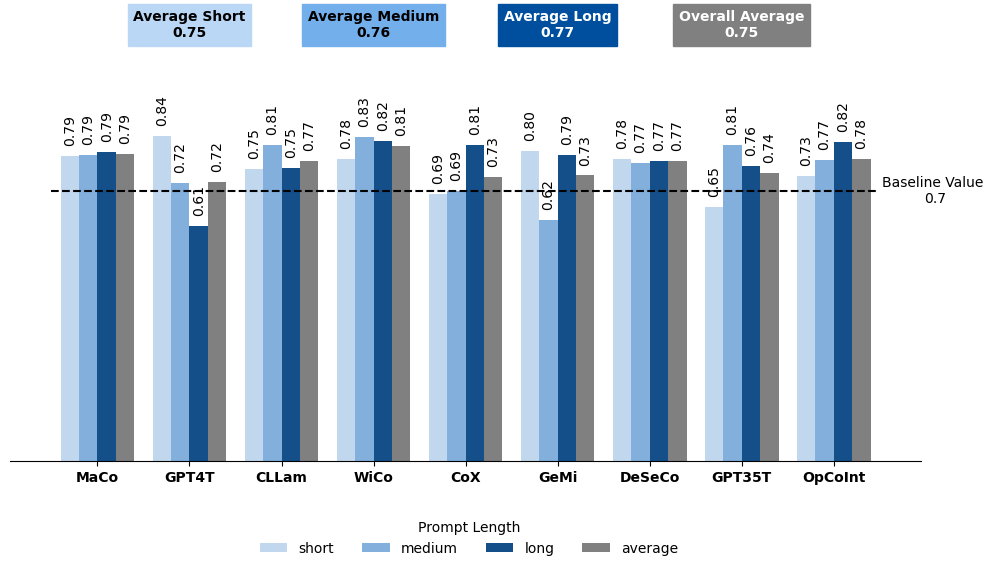

In [10]:
# Catplot
g = sns.catplot(data=hpc_maintainability[hpc_maintainability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='mi',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = hpc_maintainability[hpc_maintainability.model == 'Base']['mi'].values[0]
short_average = hpc_maintainability[hpc_maintainability.prompt == 'short']['mi'].mean()
medium_average = hpc_maintainability[hpc_maintainability.prompt == 'medium']['mi'].mean()
long_average = hpc_maintainability[hpc_maintainability.prompt == 'long']['mi'].mean()
overall_average = hpc_maintainability[hpc_maintainability.prompt == 'average']['mi'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


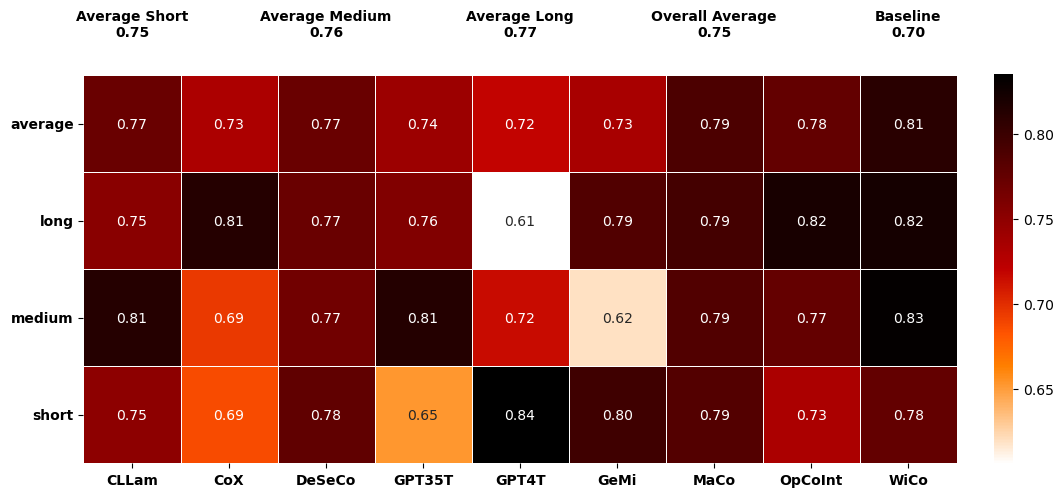

In [85]:
fig, axs = plt.subplots(figsize=(12, 8))

baseline_value = hpc_maintainability[hpc_maintainability.model == 'Base']['mi'].values[0]
short_average = hpc_maintainability[hpc_maintainability.prompt == 'short']['mi'].mean()
medium_average = hpc_maintainability[hpc_maintainability.prompt == 'medium']['mi'].mean()
long_average = hpc_maintainability[hpc_maintainability.prompt == 'long']['mi'].mean()
overall_average = hpc_maintainability[hpc_maintainability.prompt == 'average']['mi'].mean()

# Add average lines
axs.text(1-0.5, -0.4, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', size=10)
axs.text(3-0.5, -0.4, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', size=10)
axs.text(5-0.5, -0.4, f'Average Long\n{long_average:.2f}', ha='center', weight='bold',  color='black',size=10)
axs.text(7-0.5, -0.4, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', color='black',size=10)
axs.text(9-0.5, -0.4, f'Baseline\n{baseline_value:.2f}', ha='center', weight='bold', color='black',size=10)

# Maintainability heatmap
data = hpc_maintainability[hpc_maintainability.model != 'Base'][['model', 'prompt','mi']].pivot(index='model', columns='prompt', values='mi').T

sns.heatmap(data=data, cmap='gist_heat_r', annot=True, fmt=".2f", linewidths=.5, ax=axs, square=True, cbar_kws={'fraction': 0.021, 'pad':0.04}, annot_kws={"size": 10})
axs.set_xlabel('')
axs.set_ylabel('')

#plt.xticks(rotation=45)
plt.yticks(rotation=0, weight='bold')
plt.xticks(rotation=0, weight='bold')





del data

#### Code Style Composite Score

In [38]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
style_frame = hpc_maintainability.pivot(index='model',columns='prompt',values='convention')
style_frame['baseline'] = style_frame['baseline'].ffill()
style_frame = style_frame[style_frame.index != 'Base']
style_frame = style_frame[['short','medium','long','average', 'baseline']]
style_frame = style_frame.rename_axis(None, axis=1)
style_frame = pd.concat([style_frame, pd.DataFrame([style_frame.mean().values], index=['Average'], columns=style_frame.columns)], axis=0)
style_frame = style_frame.style.background_gradient(cmap='Blues', axis=None)
style_frame = style_frame.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
style_frame = style_frame.format({col: "{:.2f}" for col in style_frame.columns})
style_frame = style_frame.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
style_frame

dfi.export(style_frame, 'hpc_convention.png')

In [39]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
style_frame = hpc_maintainability.pivot(index='model',columns='prompt',values='refactor')
style_frame['baseline'] = style_frame['baseline'].ffill()
style_frame = style_frame[style_frame.index != 'Base']
style_frame = style_frame[['short','medium','long','average', 'baseline']]
style_frame = style_frame.rename_axis(None, axis=1)
style_frame = pd.concat([style_frame, pd.DataFrame([style_frame.mean().values], index=['Average'], columns=style_frame.columns)], axis=0)
style_frame = style_frame.style.background_gradient(cmap='Blues', axis=None)
style_frame = style_frame.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
style_frame = style_frame.format({col: "{:.2f}" for col in style_frame.columns})
style_frame = style_frame.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
style_frame

dfi.export(style_frame, 'hpc_refactor.png')

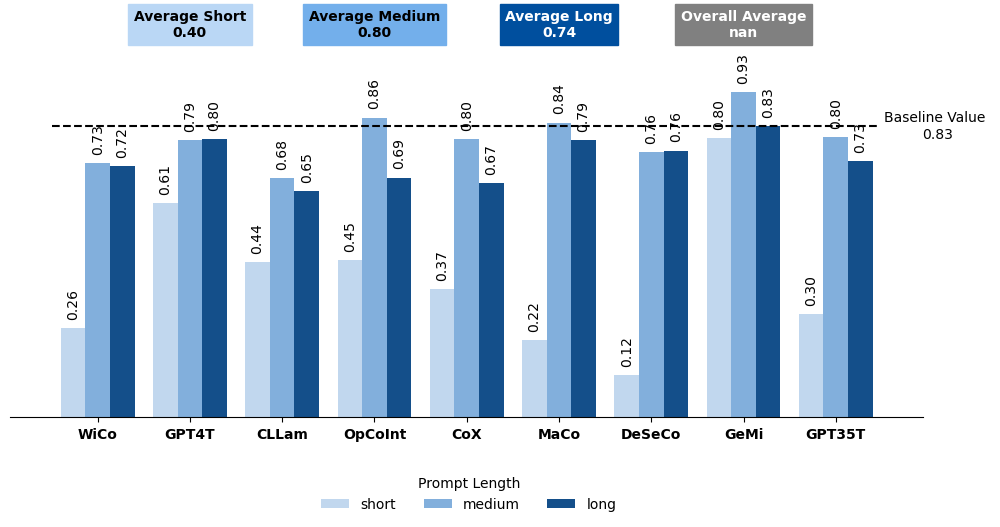

In [38]:
# Catplot
g = sns.catplot(data=hpc_maintainability[hpc_maintainability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='convention',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = hpc_maintainability[hpc_maintainability.model == 'Base']['convention'].values[0]
short_average = hpc_maintainability[hpc_maintainability.prompt == 'short']['convention'].mean()
medium_average = hpc_maintainability[hpc_maintainability.prompt == 'medium']['convention'].mean()
long_average = hpc_maintainability[hpc_maintainability.prompt == 'long']['convention'].mean()
overall_average = hpc_maintainability[hpc_maintainability.prompt == 'average']['convention'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)
#g.figure.axes.rcParams['axes.titleweight'] = 'bold'
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


#### Python Style Adherence

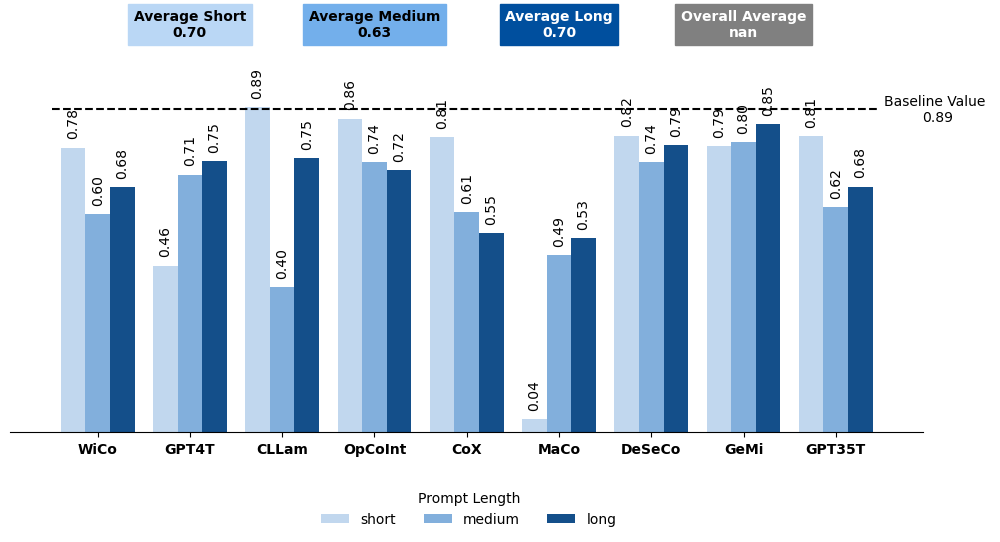

In [39]:
# Catplot
g = sns.catplot(data=hpc_maintainability[hpc_maintainability.model != 'Base'].sort_values(by='prompt', ascending=False),
                kind='bar',
                x='model',
                y='refactor',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = hpc_maintainability[hpc_maintainability.model == 'Base']['refactor'].values[0]
short_average = hpc_maintainability[hpc_maintainability.prompt == 'short']['refactor'].mean()
medium_average = hpc_maintainability[hpc_maintainability.prompt == 'medium']['refactor'].mean()
long_average = hpc_maintainability[hpc_maintainability.prompt == 'long']['refactor'].mean()
overall_average = hpc_maintainability[hpc_maintainability.prompt == 'average']['refactor'].mean()

g.set_titles('refactor')
# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


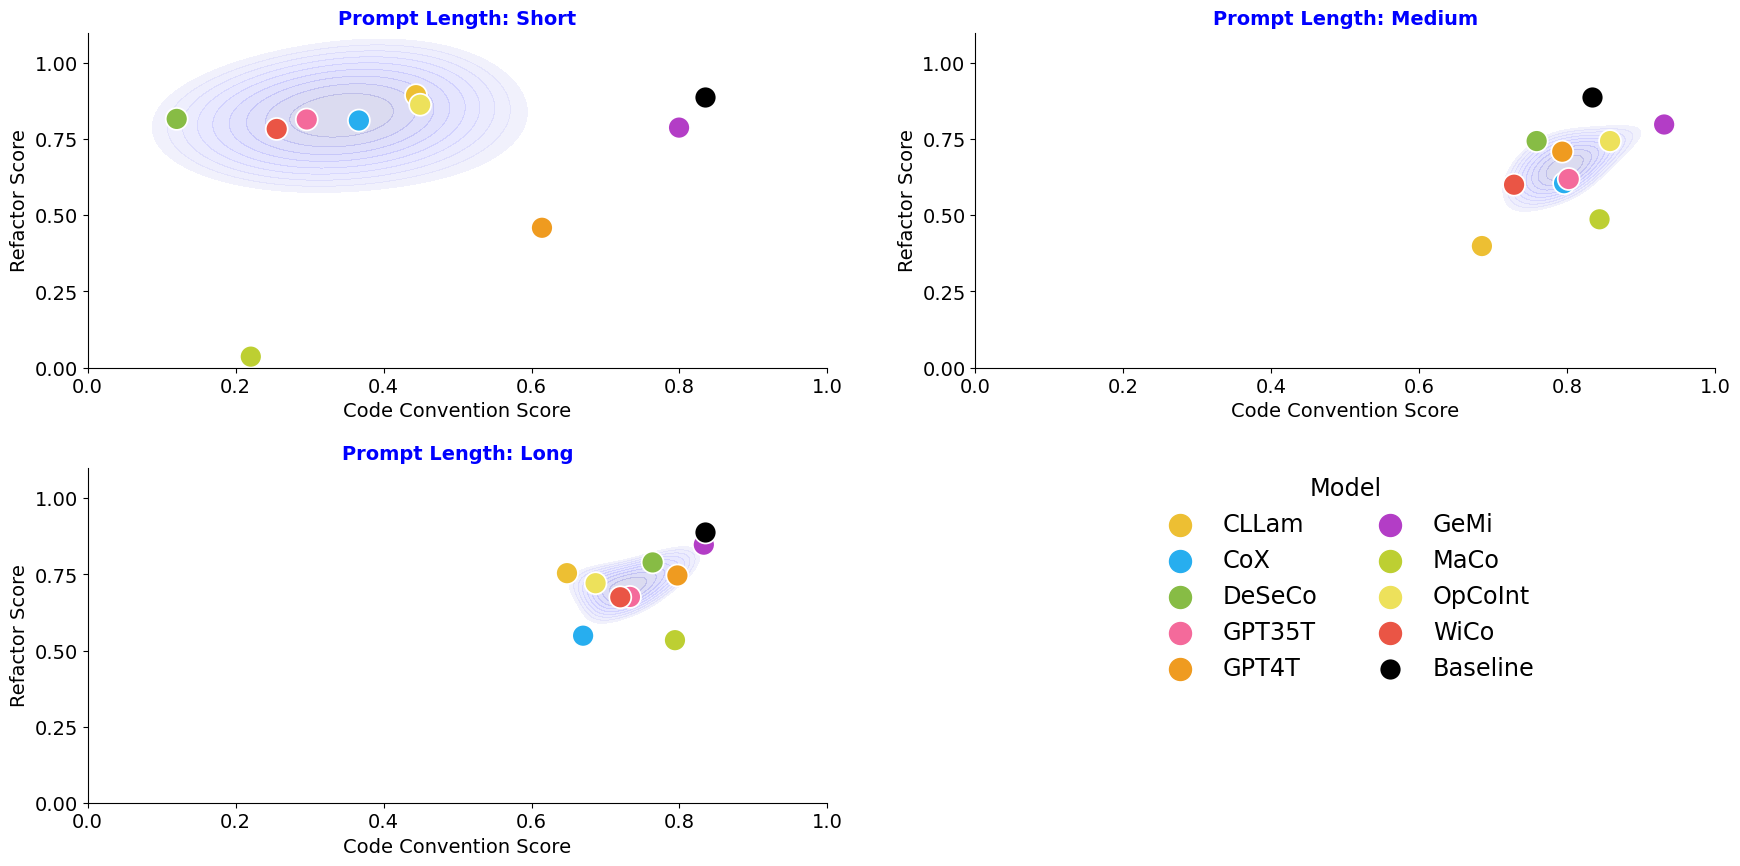

In [40]:
import matplotlib.ticker as ticker

# FILEPATH: /Users/rasmuskrebs/Documents/School/master_thesis/repo/results_visualization.ipynb
fig, axs = plt.subplots(2, 2, figsize=(21, 10))
axs = axs.flatten()


prompts = ['short', 'medium', 'long']

# Draw a contour plot to represent each bivariate density
for x, prompt in zip(list(range(3)), prompts):
    other_prompts = [p for p in prompts if p != prompt]
    axs[x].set_title(f'Prompt Length: {prompt.capitalize()}', fontsize=14, weight='bold', color='blue')

    sns.kdeplot(
        data=hpc_maintainability[-hpc_maintainability.prompt.isin(other_prompts + ['average', 'baseline'])],
        x="convention",
        y="refactor",
        color='blue',
        thresh=.6,
        linewidths=1,
        alpha=.2,
        ax=axs[x],
        #fill=True,
        shade=True,
    )

    sns.scatterplot(data=hpc_maintainability[hpc_maintainability.prompt == prompt],
                    x='convention', y='refactor', hue='model', s=250, ax=axs[x], palette=model_color_mapper)

    sns.scatterplot(data=hpc_maintainability[hpc_maintainability.prompt == 'baseline'],
                    x='convention', y='refactor', color='black',s=250, ax=axs[x], label='Baseline')

    axs[x].set_xlabel('Code Convention Score', fontsize=14)
    axs[x].set_ylabel('Refactor Score', fontsize=14)
    axs[x].tick_params(axis='both', which='major', labelsize=14)
    axs[x].yaxis.set_tick_params(labelbottom=True)
    axs[x].xaxis.set_tick_params(labelbottom=True)
    axs[x].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Set the number of ticks on the y-axis to 4
    #axs[x].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))  # Add percentage mark to y-axis
    axs[x].set_ylim(0, 1.1)
    axs[x].set_xlim(0, 1)

l = axs[0].legend(frameon=False,
              loc='lower center',
              ncol=2,
              fontsize='xx-large',
              bbox_to_anchor=(1.7, -1),
              title='Model',
              title_fontsize='xx-large')

for lh in l.legendHandles:
    lh.set_alpha(1)
    lh._sizes = [250]

axs[1].legend().remove()
axs[2].legend().remove()
sns.despine()
axs[3].axis('off')
axs[1].set_xlabel('Code Convention Score', fontsize=14)

plt.subplots_adjust(hspace = 0.3)

plt.show()

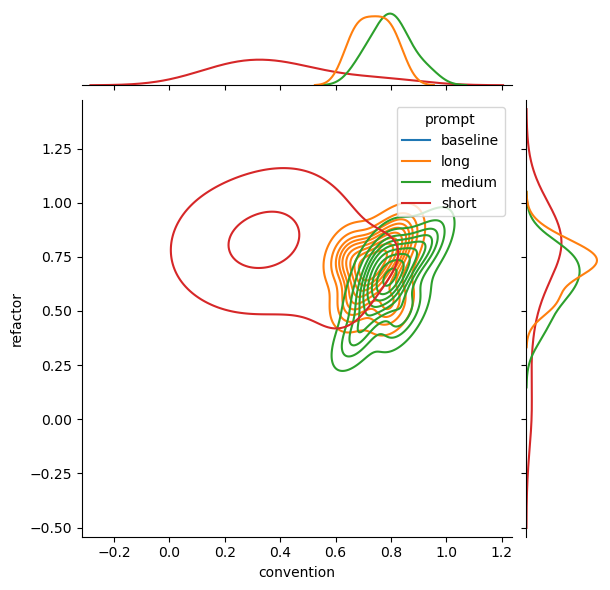

In [43]:
sns.jointplot(data=hpc_maintainability, x='convention', y='refactor', hue='prompt', kind='kde')

*Extra: Distribution of code violations for differnet algorthims in HPC*

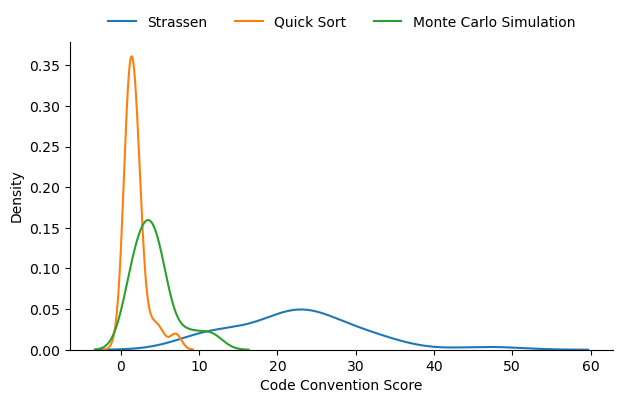

In [243]:
# Plotting convention error density for HPC

fig, axs = plt.subplots(figsize=(7, 4))

hpc_without_strassen = pd.concat([mcs,  quick_sort], axis=0).groupby(['model','prompt']).agg(np.mean).reset_index()

sns.kdeplot(data=strassen, x='convention',
             palette=prompt_palette,
             ax=axs,
             label='Strassen')

sns.kdeplot(data=quick_sort, x='convention',
             palette=prompt_palette,
             ax=axs,
             label='Quick Sort')

sns.kdeplot(data=mcs,
            x='convention', palette=prompt_palette,
            ax=axs,
            label='Monte Carlo Simulation')


axs.legend( frameon=False, loc='lower center', bbox_to_anchor=(0.50, 1), ncol=3)
axs.set_xlabel('Code Convention Score')


sns.despine(ax=axs)


#### General Code Statistics

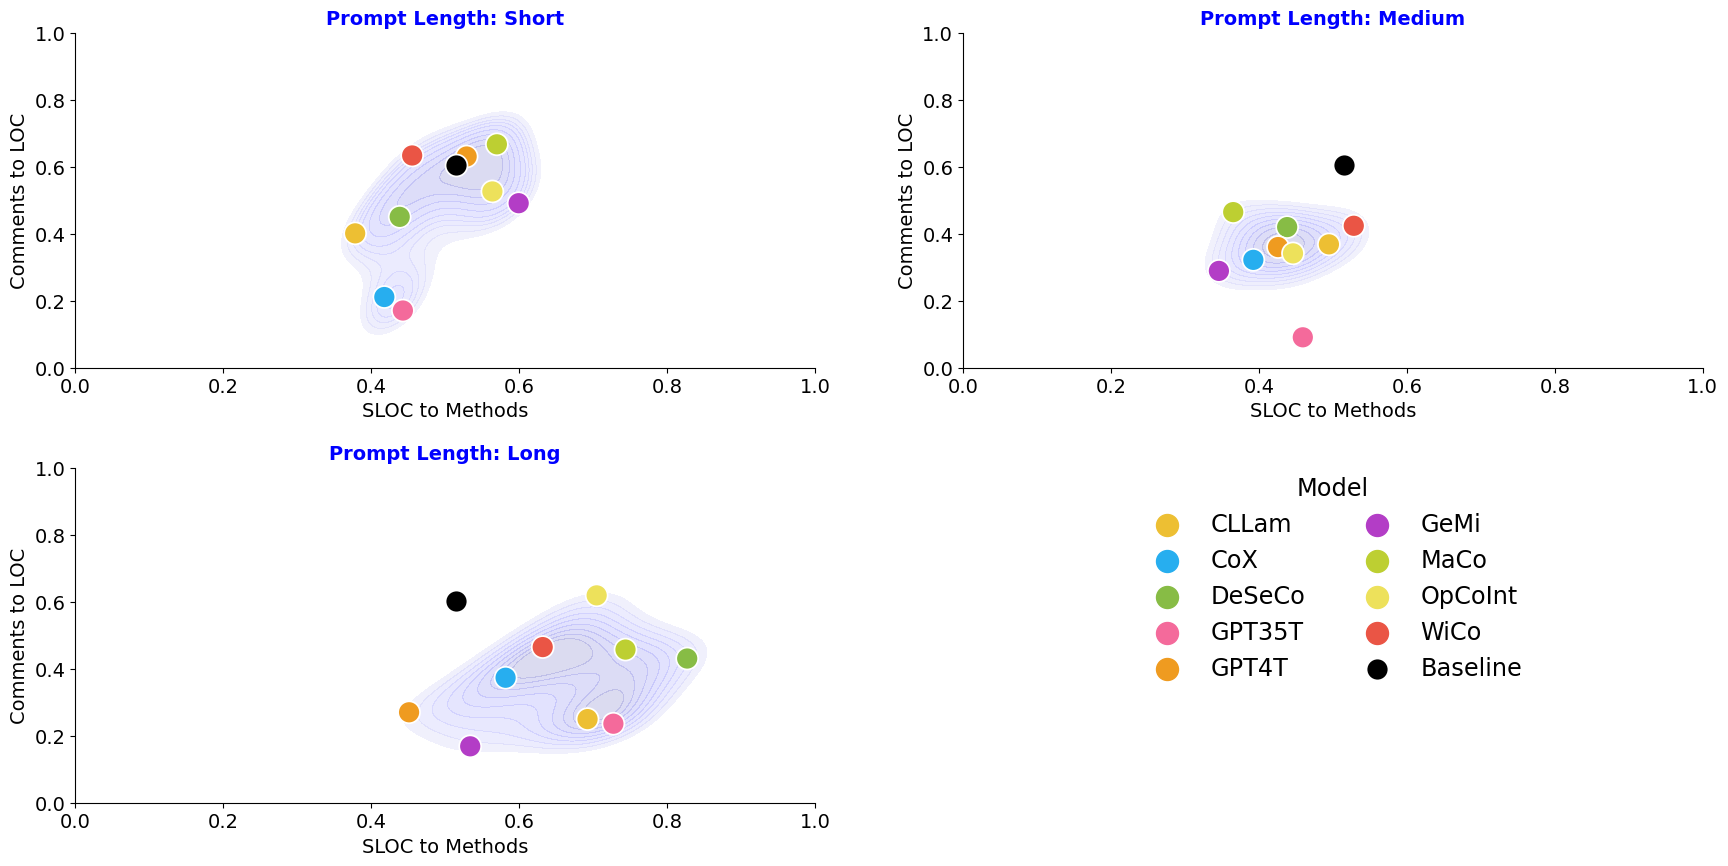

In [244]:
import matplotlib.ticker as ticker

# FILEPATH: /Users/rasmuskrebs/Documents/School/master_thesis/repo/results_visualization.ipynb
fig, axs = plt.subplots(2, 2, figsize=(21, 10))
axs = axs.flatten()


prompts = ['short', 'medium', 'long']

# Draw a contour plot to represent each bivariate density
for x, prompt in zip(list(range(3)), prompts):
    other_prompts = [p for p in prompts if p != prompt]
    axs[x].set_title(f'Prompt Length: {prompt.capitalize()}', fontsize=14, weight='bold', color='blue')
    sns.kdeplot(
        data=hpc_maintainability[-hpc_maintainability.prompt.isin(other_prompts + ['average', 'baseline'])],
        x="sloc_to_methods",
        y="comments_to_loc",
        color='blue',
        thresh=.4,
        linewidths=1,
        alpha=.2,
        ax=axs[x],
        #fill=True,
        shade=True,
    )
    sns.scatterplot(data=hpc_maintainability[hpc_maintainability.prompt == prompt],
                    x='sloc_to_methods', y='comments_to_loc', hue='model', s=250, ax=axs[x], palette=model_color_mapper)

    sns.scatterplot(data=hpc_maintainability[hpc_maintainability.prompt == 'baseline'],
                    x='sloc_to_methods', y='comments_to_loc', color='black',s=250,ax=axs[x], label='Baseline')

    axs[x].set_xlabel('SLOC to Methods', fontsize=14)
    axs[x].set_ylabel('Comments to LOC', fontsize=14)
    axs[x].tick_params(axis='both', which='major', labelsize=14)
    axs[x].yaxis.set_tick_params(labelbottom=True)
    axs[x].xaxis.set_tick_params(labelbottom=True)
    axs[x].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Set the number of ticks on the y-axis to 4
    #axs[x].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))  # Add percentage mark to y-axis
    axs[x].set_ylim(0, 1)
    axs[x].set_xlim(0, 1)

l = axs[0].legend(frameon=False,
              loc='lower center',
              ncol=2,
              fontsize='xx-large',
              bbox_to_anchor=(1.7, -1),
              title='Model',
              title_fontsize='xx-large')

for lh in l.legendHandles:
    lh.set_alpha(1)
    lh._sizes = [250]

axs[1].legend().remove()
axs[2].legend().remove()
sns.despine()
axs[3].axis('off')
#axs[1].set_xlabel('Code Convention Score', fontsize=14)

plt.subplots_adjust(hspace = 0.3)

plt.show()

#### Composite Scoring

Each of the three angles will be weighted equally, and then within each of the categories, the metrics are then weighted accordingly

In [245]:
# Breaking up the three parts to equal parts
maintainability_index = 0.33

refactor = 0.7 * 0.33
convention = 0.3 * 0.33

sloc_to_methods = 0.5 * 0.33
halstead_effort = 0.5 * 0.33

print(maintainability_index+refactor+convention+sloc_to_methods+halstead_effort)

0.99


In [246]:
hpc_maintainability.groupby(['model', 'prompt']).agg

<bound method DataFrameGroupBy.aggregate of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x2ac3ee310>>

In [247]:
hpc_maintainability['composite_score'] = ((hpc_maintainability['sloc_to_methods'] * 0.5 * 0.33) +
                                          (hpc_maintainability['comments_to_loc'] * 0.5 * 0.33) +
                                          (hpc_maintainability['mi'] * 0.33) +
                                          (hpc_maintainability['refactor'] * 0.7 * 0.33) +
                                          (hpc_maintainability['convention'] * 0.3 * 0.33))

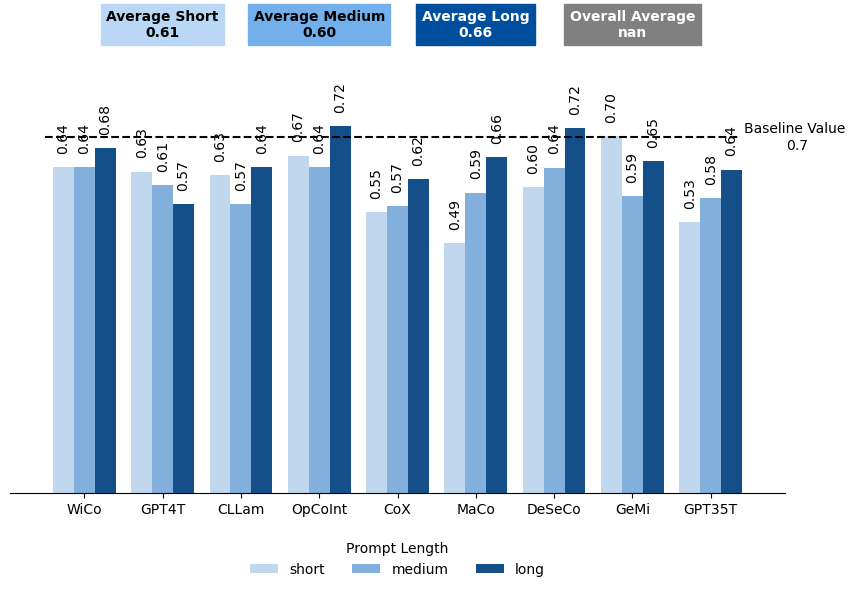

In [248]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.barplot(data=hpc_maintainability[(-hpc_maintainability.prompt.isin(['baseline'])) & (hpc_maintainability.model != 'Base')].sort_values(by='prompt', ascending=False),
            x='model', y='composite_score', hue='prompt', palette=prompt_palette)


baseline_value = hpc_maintainability[hpc_maintainability.model == 'Base']['composite_score'].values[0]
short_average = hpc_maintainability[hpc_maintainability.prompt == 'short']['composite_score'].mean()
medium_average = hpc_maintainability[hpc_maintainability.prompt == 'medium']['composite_score'].mean()
long_average = hpc_maintainability[hpc_maintainability.prompt == 'long']['composite_score'].mean()
overall_average = hpc_maintainability[hpc_maintainability.prompt == 'average']['composite_score'].mean()

# Removing y-axis
axs.set_ylabel('')
axs.set_yticks([])

# Format x-axis labels
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, ha='center')

# Add baseline line
axs.hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
axs.text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
axs.text(1, .9, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
axs.text(3, .9, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
axs.text(5, .9, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
axs.text(7, .9, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
axs.set_ylabel('')  # Remove y-axis label
axs.set_yticks([])  # Remove y-axis ticks
axs.set_xlabel('')  # Remove x-axis label

# Set legend position
axs.legend(bbox_to_anchor=(0.5, -0.25), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

sns.despine()
axs.spines['left'].set_visible(False)

# Add annotations to the bars
for p in axs.patches:
    axs.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')


plt.show()


### Performance Efficiency

In [30]:
# Load tables
strassen['algorithm'] = 'strassen'
mcs['algorithm'] = 'monte_carlo_simulation'
quick_sort['algorithm'] = 'quick_sort'

# HPC
hpc_efficiency = pd.concat([dataframe_preprocessing(strassen.copy()),
                 dataframe_preprocessing(mcs.copy()),
                 dataframe_preprocessing(quick_sort.copy())], axis=0).groupby(['model','prompt']).agg(np.mean).reset_index()

hpc_efficiency = hpc_efficiency[always_include + efficiency_metrics]

# Compute model average
average_hpc_efficiency = hpc_efficiency.groupby('model').agg(np.mean).reset_index()
average_hpc_efficiency['prompt'] = 'average'

hpc_efficiency = pd.concat([hpc_efficiency, average_hpc_efficiency], axis=0)


#### CPU Usage 

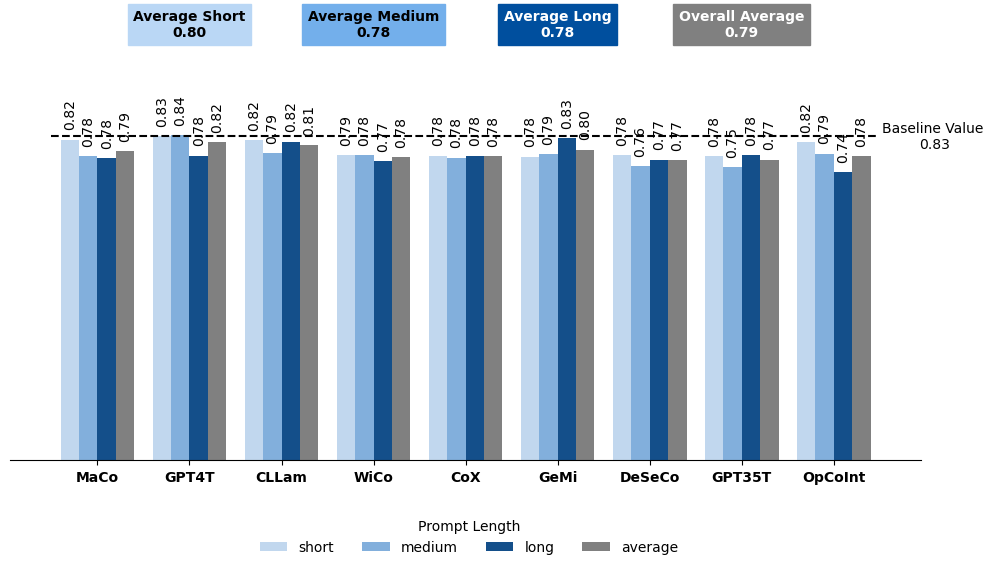

In [31]:
# Catplot
g = sns.catplot(data=hpc_efficiency[hpc_efficiency.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='cpu',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = hpc_efficiency[hpc_efficiency.model == 'Base']['cpu'].values[0]
short_average = hpc_efficiency[hpc_efficiency.prompt == 'short']['cpu'].mean()
medium_average = hpc_efficiency[hpc_efficiency.prompt == 'medium']['cpu'].mean()
long_average = hpc_efficiency[hpc_efficiency.prompt == 'long']['cpu'].mean()
overall_average = hpc_efficiency[hpc_efficiency.prompt == 'average']['cpu'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


#### Memory Usage

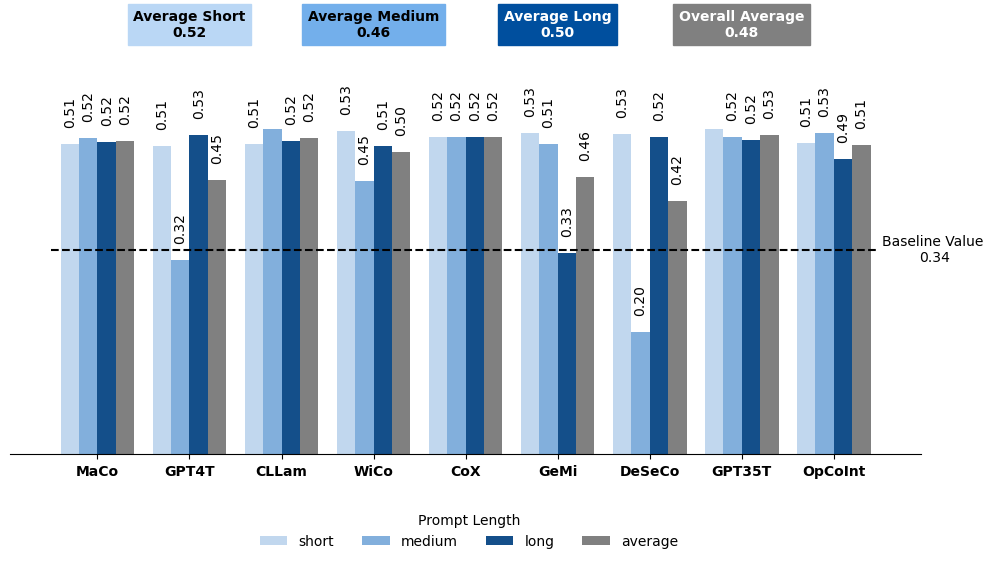

In [32]:
# Catplot
g = sns.catplot(data=hpc_efficiency[hpc_efficiency.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='memory_usage',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = hpc_efficiency[hpc_efficiency.model == 'Base']['memory_usage'].values[0]
short_average = hpc_efficiency[hpc_efficiency.prompt == 'short']['memory_usage'].mean()
medium_average = hpc_efficiency[hpc_efficiency.prompt == 'medium']['memory_usage'].mean()
long_average = hpc_efficiency[hpc_efficiency.prompt == 'long']['memory_usage'].mean()
overall_average = hpc_efficiency[hpc_efficiency.prompt == 'average']['memory_usage'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 0.69, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 0.69, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 0.69, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 0.69, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


#### Composite

In [33]:
hpc_efficiency['composite_score'] = (hpc_efficiency['cpu'] * 0.5) + (hpc_efficiency['memory_usage'] * 0.5)

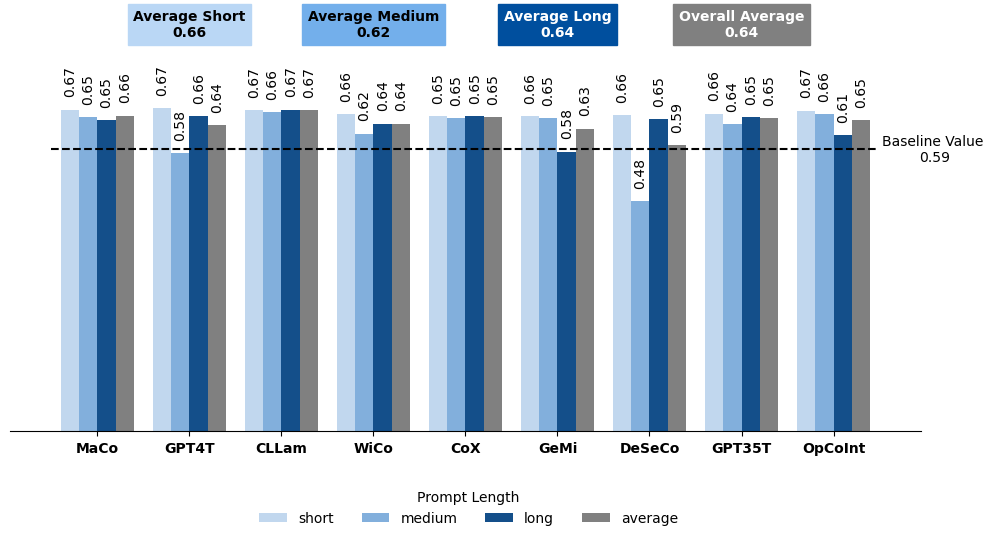

In [56]:
# Catplot
g = sns.catplot(data=hpc_efficiency[hpc_efficiency.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='composite_score',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = hpc_efficiency[hpc_efficiency.model == 'Base']['composite_score'].values[0]
short_average = hpc_efficiency[hpc_efficiency.prompt == 'short']['composite_score'].mean()
medium_average = hpc_efficiency[hpc_efficiency.prompt == 'medium']['composite_score'].mean()
long_average = hpc_efficiency[hpc_efficiency.prompt == 'long']['composite_score'].mean()
overall_average = hpc_efficiency[hpc_efficiency.prompt == 'average']['composite_score'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 0.82, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 0.82, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 0.82, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 0.82, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


### Security

In [17]:
hpc_security['security'] = (hpc_security['security_low'] * 1/3) + (hpc_security['warnings'] * 1/3) + (hpc_security['errors'] * 1/3)

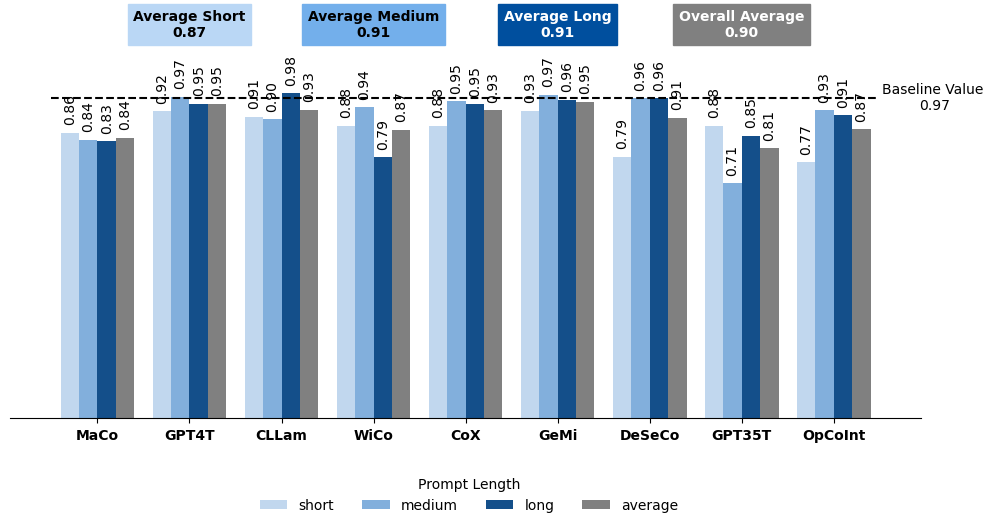

In [18]:
# Catplot
g = sns.catplot(data=hpc_security[hpc_security.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='security',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = hpc_security[hpc_security.model == 'Base']['security'].values[0]
short_average = hpc_security[hpc_security.prompt == 'short']['security'].mean()
medium_average = hpc_security[hpc_security.prompt == 'medium']['security'].mean()
long_average = hpc_security[hpc_security.prompt == 'long']['security'].mean()
overall_average = hpc_security[hpc_security.prompt == 'average']['security'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.15, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.15, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.15, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.15, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


## Reliability

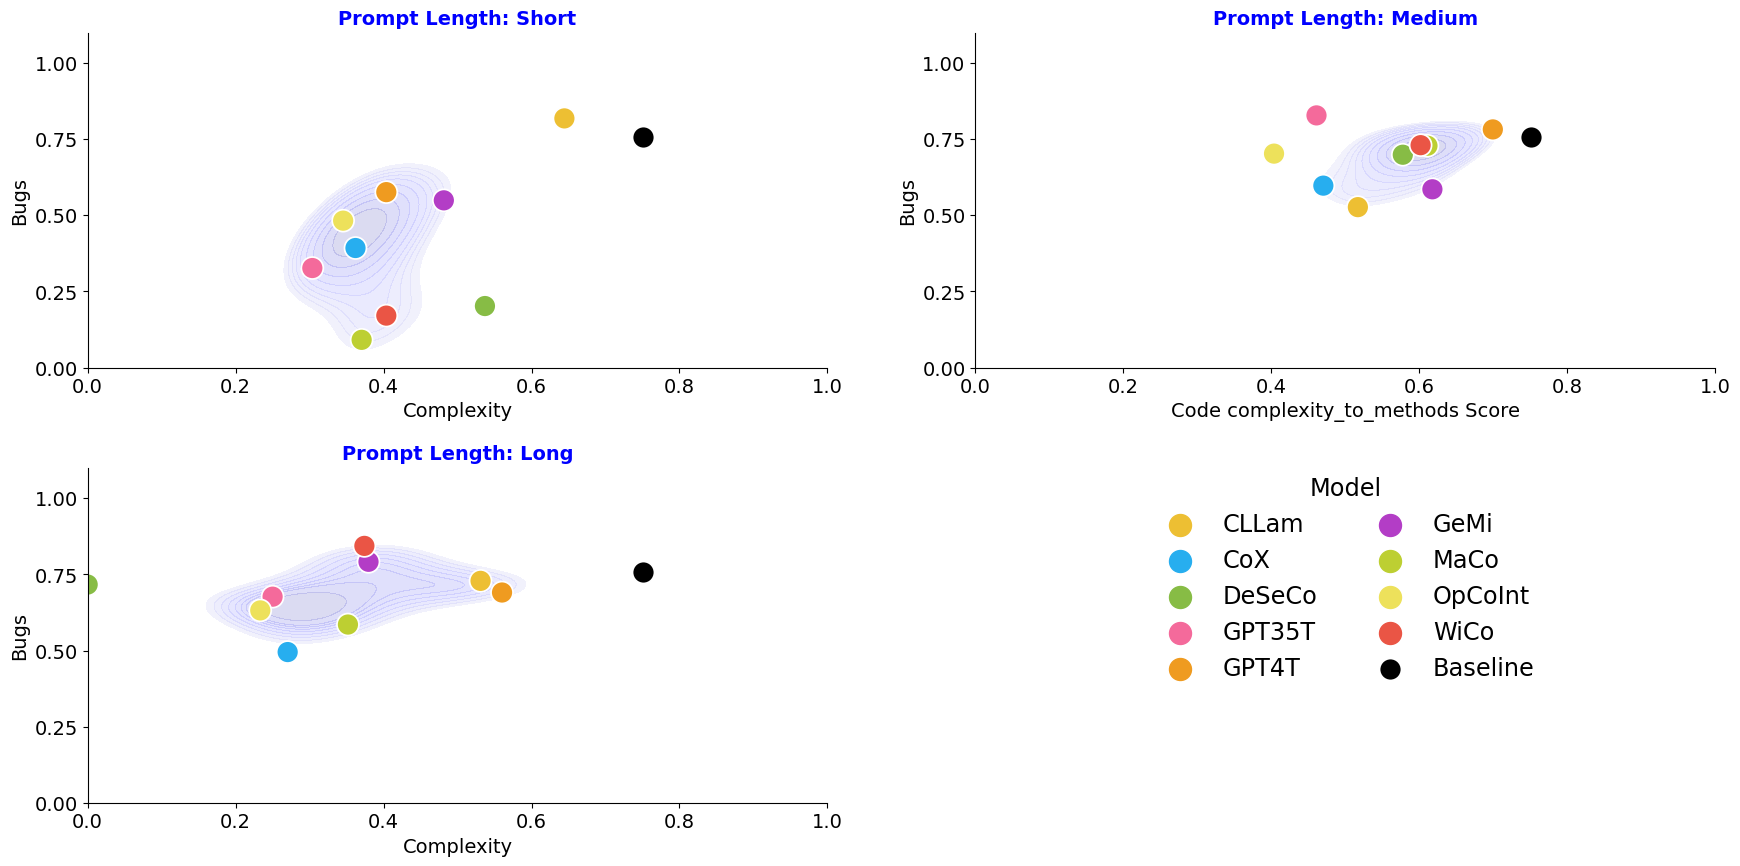

In [10]:
import matplotlib.ticker as ticker

# FILEPATH: /Users/rasmuskrebs/Documents/School/master_thesis/repo/results_visualization.ipynb
fig, axs = plt.subplots(2, 2, figsize=(21, 10))
axs = axs.flatten()


prompts = ['short', 'medium', 'long']

# Draw a contour plot to represent each bivariate density
for x, prompt in zip(list(range(3)), prompts):
    other_prompts = [p for p in prompts if p != prompt]
    axs[x].set_title(f'Prompt Length: {prompt.capitalize()}', fontsize=14, weight='bold', color='blue')

    sns.kdeplot(
        data=hpc_reliability[-hpc_reliability.prompt.isin(other_prompts + ['average', 'baseline'])],
        x="complexity_to_methods",
        y="halstead_bugs",
        color='blue',
        thresh=.6,
        linewidths=1,
        alpha=.2,
        ax=axs[x],
        #fill=True,
        shade=True,
    )

    sns.scatterplot(data=hpc_reliability[hpc_reliability.prompt == prompt],
                    x='complexity_to_methods', y='halstead_bugs', hue='model', s=250, ax=axs[x], palette=model_color_mapper)

    sns.scatterplot(data=hpc_reliability[hpc_reliability.prompt == 'baseline'],
                    x='complexity_to_methods', y='halstead_bugs', color='black',s=250, ax=axs[x], label='Baseline')

    axs[x].set_xlabel('Complexity', fontsize=14)
    axs[x].set_ylabel('Bugs', fontsize=14)
    axs[x].tick_params(axis='both', which='major', labelsize=14)
    axs[x].yaxis.set_tick_params(labelbottom=True)
    axs[x].xaxis.set_tick_params(labelbottom=True)
    axs[x].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Set the number of ticks on the y-axis to 4
    #axs[x].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))  # Add percentage mark to y-axis
    axs[x].set_ylim(0, 1.1)
    axs[x].set_xlim(0, 1)

l = axs[0].legend(frameon=False,
              loc='lower center',
              ncol=2,
              fontsize='xx-large',
              bbox_to_anchor=(1.7, -1),
              title='Model',
              title_fontsize='xx-large')

for lh in l.legendHandles:
    lh.set_alpha(1)
    lh._sizes = [250]

axs[1].legend().remove()
axs[2].legend().remove()
sns.despine()
axs[3].axis('off')
axs[1].set_xlabel('Code complexity_to_methods Score', fontsize=14)

plt.subplots_adjust(hspace = 0.3)

plt.show()

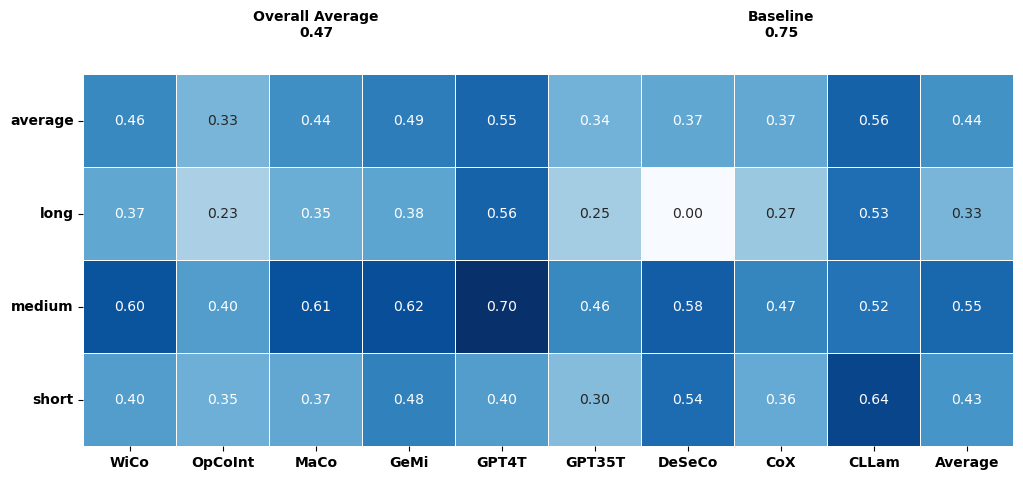

In [11]:
fig, axs = plt.subplots(figsize=(12, 8))

baseline_value = hpc_reliability[hpc_reliability.model == 'Base']['complexity_to_methods'].values[0]
short_average = hpc_reliability[hpc_reliability.prompt == 'short']['complexity_to_methods'].mean()
medium_average = hpc_reliability[hpc_reliability.prompt == 'medium']['complexity_to_methods'].mean()
long_average = hpc_reliability[hpc_reliability.prompt == 'long']['complexity_to_methods'].mean()
overall_average = hpc_reliability[hpc_reliability.prompt == 'average']['complexity_to_methods'].mean()

# Add average lines
# axs.text(1-0.5, -0.4, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', size=10)
# axs.text(3-0.5, -0.4, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', size=10)
# axs.text(5-0.5, -0.4, f'Average Long\n{long_average:.2f}', ha='center', weight='bold',  color='black',size=10)
axs.text(2.5, -0.4, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', color='black',size=10)
axs.text(7.5, -0.4, f'Baseline\n{baseline_value:.2f}', ha='center', weight='bold', color='black',size=10)

# Maintainability heatmap
data = hpc_reliability[hpc_reliability.model != 'Base'][['model', 'prompt','complexity_to_methods']]
data_0 = hpc_reliability[hpc_reliability.model != 'Base'].groupby(['prompt']).agg(np.mean).reset_index()
data_0['model'] = 'Average'
data = pd.concat([data_0,data], axis=0)
data = data.pivot(index='model', columns='prompt', values='complexity_to_methods').T
data = data.iloc[:, ::-1]

sns.heatmap(data=data, cmap='Blues', annot=True, fmt=".2f", linewidths=.5, ax=axs, square=True,
            cbar=False,
            cbar_kws={'fraction': 0.021, 'pad':0.04}, annot_kws={"size": 10})
axs.set_xlabel('')
axs.set_ylabel('')

#plt.xticks(rotation=45)
plt.yticks(rotation=0, weight='bold')
plt.xticks(rotation=0, weight='bold')

plt.show()

del data

In [12]:
df.drop('column_name', axis=1, inplace=True)


KeyError: "['column_name'] not found in axis"

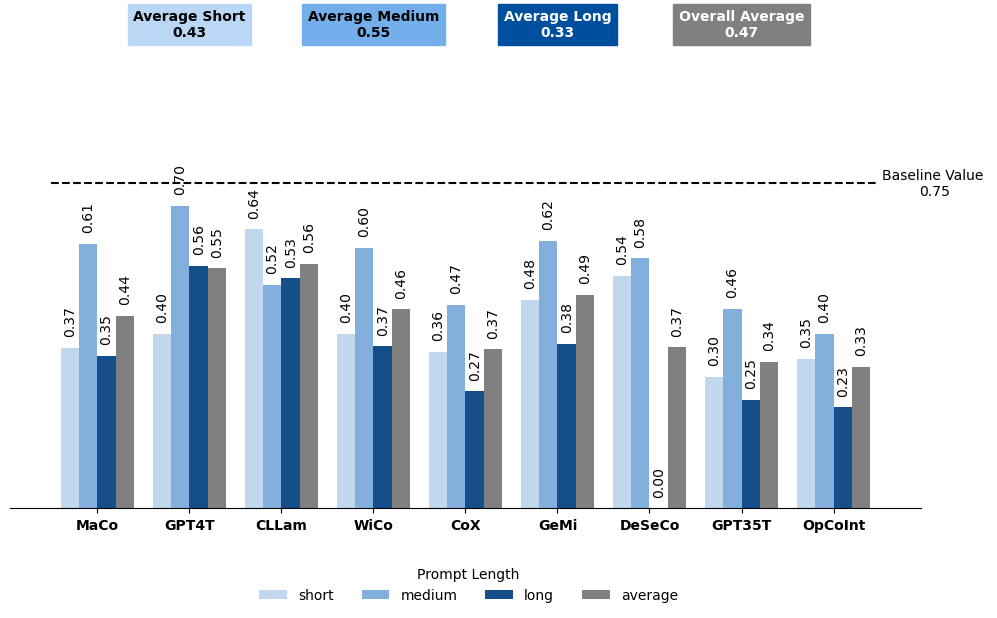

In [13]:
# Catplot
g = sns.catplot(data=hpc_reliability[hpc_reliability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='complexity_to_methods',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = hpc_reliability[hpc_reliability.model == 'Base']['complexity_to_methods'].values[0]
short_average = hpc_reliability[hpc_reliability.prompt == 'short']['complexity_to_methods'].mean()
medium_average = hpc_reliability[hpc_reliability.prompt == 'medium']['complexity_to_methods'].mean()
long_average = hpc_reliability[hpc_reliability.prompt == 'long']['complexity_to_methods'].mean()
overall_average = hpc_reliability[hpc_reliability.prompt == 'average']['complexity_to_methods'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


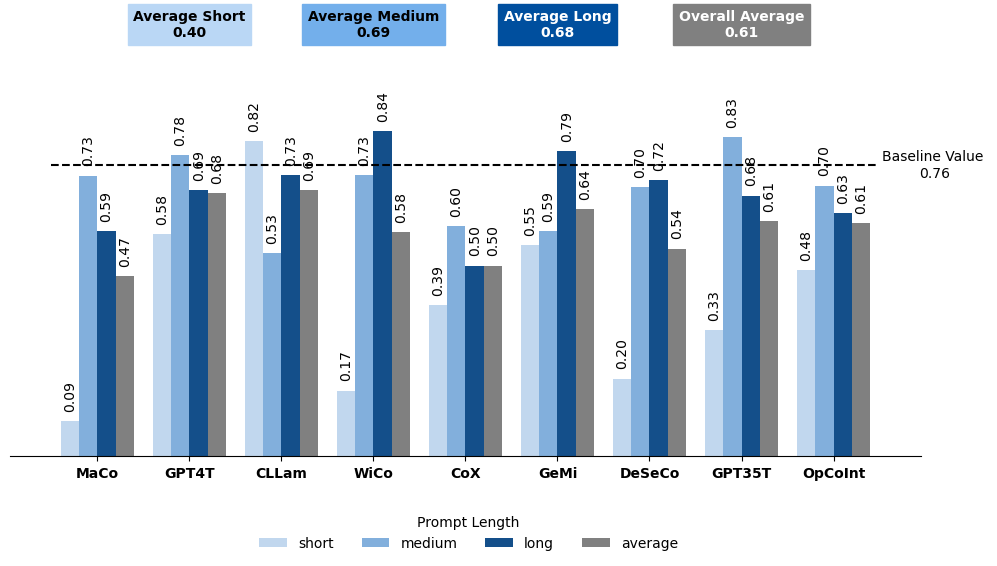

In [14]:
# Catplot
g = sns.catplot(data=hpc_reliability[hpc_reliability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='halstead_bugs',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = hpc_reliability[hpc_reliability.model == 'Base']['halstead_bugs'].values[0]
short_average = hpc_reliability[hpc_reliability.prompt == 'short']['halstead_bugs'].mean()
medium_average = hpc_reliability[hpc_reliability.prompt == 'medium']['halstead_bugs'].mean()
long_average = hpc_reliability[hpc_reliability.prompt == 'long']['halstead_bugs'].mean()
overall_average = hpc_reliability[hpc_reliability.prompt == 'average']['halstead_bugs'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


In [15]:
bugs = hpc_reliability[['model','prompt','halstead_bugs', 'complexity_to_methods']]

In [16]:
import dataframe_image as dfi

#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs['halsted_bugs'] = bugs['halstead_bugs'].astype(float)
bugs_style = bugs.pivot(index='model',columns='prompt',values='halstead_bugs')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '10px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style

dfi.export(bugs_style, 'hpc_bugs.png')

In [311]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = bugs.pivot(index='model',columns='prompt',values='complexity_to_methods')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
dfi.export(bugs_style, 'hpc_comblexity.png')

In [29]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = hpc_reliability.pivot(index='model',columns='prompt',values='errors')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
dfi.export(bugs_style, 'errors.png')

In [31]:
hpc_reliability['composite'] = (hpc_reliability['complexity_to_methods'] * 0.25) + (hpc_reliability['halstead_bugs'] * 0.25) + (hpc_reliability['errors'] * 0.25) + (hpc_reliability['warnings'] * 0.25)

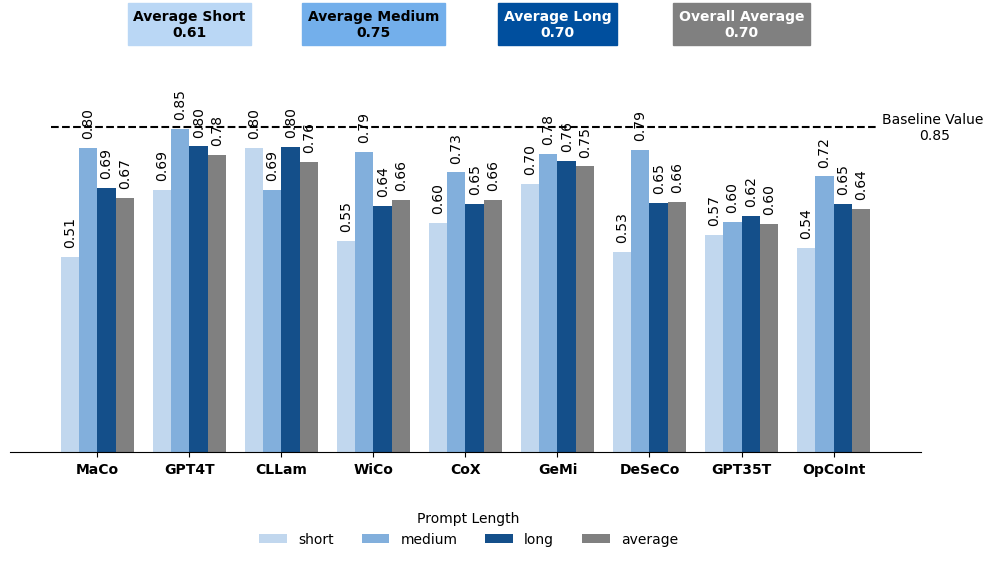

In [33]:
hpc_reliability['composite_score'] = (hpc_reliability['complexity_to_methods'] * 0.25) + (hpc_reliability['halstead_bugs'] * 0.25) + (hpc_reliability['errors'] * 0.25) + (hpc_reliability['warnings'] * 0.25)

# Catplot
g = sns.catplot(data=hpc_reliability[hpc_reliability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='composite_score',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = hpc_reliability[hpc_reliability.model == 'Base']['composite_score'].values[0]
short_average = hpc_reliability[hpc_reliability.prompt == 'short']['composite_score'].mean()
medium_average = hpc_reliability[hpc_reliability.prompt == 'medium']['composite_score'].mean()
long_average = hpc_reliability[hpc_reliability.prompt == 'long']['composite_score'].mean()
overall_average = hpc_reliability[hpc_reliability.prompt == 'average']['composite_score'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


## ML

In [253]:
# ML
ml = pd.concat([dataframe_preprocessing(convolution),
                 dataframe_preprocessing(attention),
                 dataframe_preprocessing(pca)], axis=0).groupby(['model','prompt']).agg(np.mean).reset_index()

# Compute model average
average_ml = ml.groupby('model').agg(np.mean).reset_index()
average_ml['prompt'] = 'average'

ml = pd.concat([ml, average_ml], axis=0)

ml = ml.replace({'small':'short'})

In [13]:
# Seperating
always_include = ['model','prompt']

ml_efficiency = ml[always_include + efficiency_metrics]
ml_security = ml[always_include + security_metrics]
ml_reliability = ml[always_include + reliability_metrics]
ml_maintainability = ml[always_include + maintainability_metrics]


#code_convention_composite_score = {'convention': 0.3, 'refactor': 0.7}
#hpc_maintainability['code_convention_composite_score'] = hpc_maintainability['convention'] * code_convention_composite_score['convention'] + hpc_maintainability['refactor'] * code_convention_composite_score['refactor']

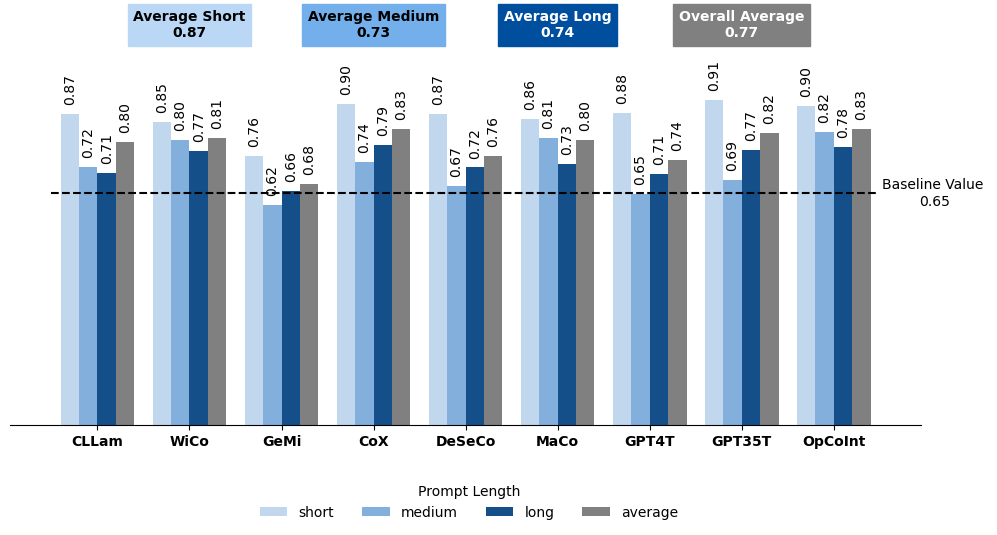

In [17]:
# Catplot
g = sns.catplot(data=ml_maintainability[ml_maintainability.model != 'Base'].sort_values(by='prompt', ascending=False),
                kind='bar',
                x='model',
                y='mi',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = ml_maintainability[ml_maintainability.model == 'Base']['mi'].values[0]
short_average = ml_maintainability[ml_maintainability.prompt == 'short']['mi'].mean()
medium_average = ml_maintainability[ml_maintainability.prompt == 'medium']['mi'].mean()
long_average = ml_maintainability[ml_maintainability.prompt == 'long']['mi'].mean()
overall_average = ml_maintainability[ml_maintainability.prompt == 'average']['mi'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


In [ ]:
# Catplot
g = sns.catplot(data=ml_maintainability[ml_maintainability.model != 'Base'].sort_values(by='prompt', ascending=False),
                kind='bar',
                x='model',
                y='mi',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = ml_maintainability[ml_maintainability.model == 'Base']['mi'].values[0]
short_average = ml_maintainability[ml_maintainability.prompt == 'short']['mi'].mean()
medium_average = ml_maintainability[ml_maintainability.prompt == 'medium']['mi'].mean()
long_average = ml_maintainability[ml_maintainability.prompt == 'long']['mi'].mean()
overall_average = ml_maintainability[ml_maintainability.prompt == 'average']['mi'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


# Archived

In [ ]:
# Metrics used
reliability_metrics = ["Errors (E)", "Warnings (W)", "Cyclomatic Complexity", "Halstead Bugs"]
maintainability_metrics = ["Maintainability Index", "Refactoring Checks (R)", "Style Convenetion Errors (C)", "comments-to-lines", "SLOC/Methods"]
performance_metrics = ['Total Memory Usage (MiB)', 'CPU Usage Per Cent']
security_metrics = ["Warnings (W)", "Errors (E)", "Pylint Rating"]

# Unique metrics
metrics = list(set(reliability_metrics + maintainability_metrics + performance_metrics + security_metrics)) + ['Metric']
df0 = df0[metrics]

In [ ]:
# Scaling the data
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
scaling_metrics = df0.iloc[:, :-1].columns # ['Total Memory Usage (MiB)','Halstead Bugs','Style Convenetion Errors (C)', 'Warnings (W)', 'SLOC/Methods', 'Refactoring Checks (R)', 'Cyclomatic Complexity', 'Errors (E)']

# Normalize the metrics
normalized = scaler.fit_transform(df0[scaling_metrics])
df_normalized = pd.DataFrame(normalized, columns=scaling_metrics, index=df0.index)
df_normalized['Metric'] = df0['Metric']
# df_normalized.index = df.index

# Partitioning datasets
long = df_normalized[(df_normalized.Metric == "Long") | (df_normalized.Metric.isna())]
medium = df_normalized[(df_normalized.Metric == "Medium") | (df_normalized.Metric.isna())]
small = df_normalized[(df_normalized.Metric == "Small") | (df_normalized.Metric.isna())]


### Helpers

In [ ]:
# Partitioning dataframe into ISO 5055
def iso_partion(df:pd.DataFrame, metrics: list):
    return df[metrics]

In [ ]:
# Generate composite score
def composite_score(df, metrics, weights, negative = False):

    # Initialize the MinMaxScaler
    #scaler = MinMaxScaler()

    # Normalize the metrics
    # df_normalized = scaler.fit_transform(df[metrics])
    # df_normalized = pd.DataFrame(df_normalized, columns=metrics)
    # df_normalized.index = df.index
    #
    # Compute the composite score
    df['composite_score'] = df.apply(lambda x: sum(x[metric] * weight for metric, weight in weights.items()), axis=1)

    # If negative, then reverse the composite score
    if negative:
        df['composite_score'] = -df['composite_score']

    return df


In [ ]:
# palette = sns.color_palette(['red','green','blue'])#'#182787','#4754a8', '#818bcc'])
palette = sns.color_palette(['#3F92A8','#e2c222','#E43307'])#'#182787','#4754a8', '#818bcc'])

## ISO Partioning
See notion [here](https://www.notion.so/raskrebs/ISO-5055-Metric-Groupings-aabc91707db0428f91a2ffd4296b0814?pvs=4)

In [ ]:
# Model renaming
model_names = {"Codex":"Codex",
 "DeepSeeker-Coder":"DeSe-Co",
 "WizardCoder":"WiCo",
 "Tabnine":"T9",
 "GPT 4":"GPT4",
 "GPT 3.5":"GPT35",
 "Gemini/Bard":"Gemini",
 "CodeLLama":"CLLam",
 }

### Reliability

In [ ]:
def relaibility(df_length, version):
    # Relability Comsposite Score
    weights = {"Errors (E)": 0.25,
               "Warnings (W)": 0.25,
               "Cyclomatic Complexity": 0.3,
               "Halstead Bugs": 0.2}


    metrics = weights.keys()

    assert sum(weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(weights.values()))

    # Maintainability long
    df = df_length[metrics]

    # Subtracting from 1, such that the higher the score, the better
    for metric in metrics:
        df[metric] =  1 - df[metric]

    # Compute the composite score
    df = composite_score(df,
                         metrics,
                         weights)
    # Resetting index
    df['model'] = df.index
    df = df.reset_index(drop=True)

    # Sorting by composite score
    df = df.sort_values(by="composite_score", ascending=False)
    df['version'] = version

    return df

In [ ]:
# Transform
long_relaibility = relaibility(long, 'long')
medium_relaibility = relaibility(medium, 'medium')
small_relaibility = relaibility(small, 'small')

In [ ]:
# Concatenating the data
concat_columns = ['model', 'version', 'composite_score']
relaibility_plot_data = pd.concat([long_relaibility[concat_columns], medium_relaibility[concat_columns], small_relaibility[concat_columns]])
relaibility_plot_data = relaibility_plot_data[relaibility_plot_data.model != 'Baseline']
relaibility_plot_data.model = relaibility_plot_data.model.map(model_names)
baseline_value = long_relaibility[long_relaibility.model == 'Baseline'].composite_score.values[0]

# Plotting
g = sns.catplot(data=relaibility_plot_data,
                kind='bar',
                x='model',
                y='composite_score',
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, baseline_value, f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
#g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()

### Maintainability

In [ ]:
def maintainability(df_length, version):
    # Weights for maintainability composite score
    weights = {
        'Refactoring Checks (R)': 0.25,  # Low severity
        'Style Convenetion Errors (C)': 0.15,  # Low severity
        "comments-to-lines": .2, # The higher the ratio, the better the maintainability as more documentation is provided
        "SLOC/Methods": 0.2, # High ratio indicates low maintainability as they are likely then more complex and harder to maintain
        'Maintainability Index': 0.2  # Direct measure of maintainability, so just balanced. It's not given a higher weights since MIs between 60-100 are generally considered good
        }


    metrics = weights.keys()

    assert sum(weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(weights.values()))

    # Maintainability long
    df = df_length[metrics]

    # Maintainability specific preprocessing: Invert all scores, where closer to zero is better
    # df['Refactoring Checks (R)'] *= -1
    # df['Style Convenetion Errors (C)'] *= -1
    # df['SLOC/Methods'] *= -1
    df['Refactoring Checks (R)'] = 1 - df['Refactoring Checks (R)']
    df['Style Convenetion Errors (C)'] = 1 - df['Style Convenetion Errors (C)']
    df['SLOC/Methods'] = 1 - df['SLOC/Methods']


    # Compute the composite score
    df = composite_score(df,
                         metrics,
                         weights)

    # Resetting index
    df['model'] = df.index
    df = df.reset_index(drop=True)

    # Sorting by composite score
    df = df.sort_values(by="composite_score", ascending=False)
    df['version'] = version

    return df

In [ ]:
# Compute the composite score
maintainability_long = maintainability(long, 'long')
maintainability_medium = maintainability(medium, 'medium')
maintainability_small = maintainability(small, 'small')

In [ ]:
# Concatenating the data
maintainability_plot_data = pd.concat([maintainability_long[concat_columns], maintainability_medium[concat_columns], maintainability_small[concat_columns]])
maintainability_plot_data = maintainability_plot_data[maintainability_plot_data.model != 'Baseline']
baseline_value = maintainability_long[maintainability_long.model == 'Baseline'].composite_score.values[0]
maintainability_plot_data.model = maintainability_plot_data.model.map(model_names)

# Plotting
g = sns.catplot(data=maintainability_plot_data,
                kind='bar',
                x='model',
                y='composite_score',
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Maintainability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(maintainability_long[maintainability_long.model == 'Baseline'].composite_score.values[0], -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, maintainability_long[maintainability_long.model == 'Baseline'].composite_score.values[0], f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
#g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()

### Performance Efficiency

In [ ]:
def performance(length, version):
    # Weights for performance composite score
    weights = {
        'Total Memory Usage (MiB)' : 0.5,
        'CPU Usage Per Cent' : 0.5}

    metrics = weights.keys()

    assert sum(weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(weights.values()))

    # Maintainability long
    df = length[metrics]

    # Invert the CPU Usage Per Cent to ensure higher scores indicate better performance
    df['CPU Usage Per Cent'] = 1 - df['CPU Usage Per Cent']
    df['Total Memory Usage (MiB)'] = 1 - df['Total Memory Usage (MiB)']

    # Compute the composite score
    df = composite_score(df,
                         metrics,
                         weights)

    # Resetting index
    df['model'] = df.index
    df = df.reset_index(drop=True)

    # Sorting by composite score
    df = df.sort_values(by="composite_score", ascending=False)
    df['version'] = version

    return df

In [ ]:
# Compute the composite score
performance_long = performance(long, 'long')
performance_medium = performance(medium, 'medium')
performance_small = performance(small, 'small')

In [ ]:

performance_plot_data = pd.concat([performance_long[concat_columns], performance_medium[concat_columns], performance_small[concat_columns]])
performance_plot_data = performance_plot_data[performance_plot_data.model != 'Baseline']
baseline_value = performance_long[performance_long.model == 'Baseline'].composite_score.values[0]
performance_plot_data.model = performance_plot_data.model.map(model_names)

# Plotting
g = sns.catplot(data=performance_plot_data,
                kind='bar',
                x='model',
                y='composite_score',
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Performance', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(performance_long[performance_long.model == 'Baseline'].composite_score.values[0], -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, performance_long[performance_long.model == 'Baseline'].composite_score.values[0], f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
#g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()

### Security
*Static code checks can indirectly relate to security by encouraging good coding practices that can prevent certain types of vulnerabilities, but generally these are only indicative. Security is overall difficult to test for using only static code analysis*

In [ ]:
def security(df_length, version):
    # Weights for security composite score.
    security_weights = {
        "Warnings (W)": .3,
        "Errors (E)": .3,
        "Pylint Rating": .4,
    }


    # Metrics from long to include
    security_metrics = security_weights.keys()

    assert sum(security_weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(security_weights.values()))

    # Security long
    df = df_length[security_metrics]

    # Invert the negative scores, such that these negatively influence the rating
    df['Warnings (W)'] = 1 - df['Warnings (W)']
    df['Errors (E)'] = 1 - df['Errors (E)']


    # Compute the composite score
    df = composite_score(df,
                                   security_metrics,
                                   security_weights)

    # df['composite_score'] /= 3

    # Assign model to column rather than index
    df['model'] = df.index
    df = df.reset_index(drop=True)

    # Add version
    df['version'] = version

    return df

In [ ]:
security_long = security(long,'long')
security_medium = security(medium,'medium')
security_small = security(small,'small')

In [ ]:

# fig, axs = plt.subplots(figsize=(11, 4))
security_plot_data = pd.concat([security_long[concat_columns], security_medium[concat_columns], security_small[concat_columns]])
security_plot_data = security_plot_data[security_plot_data.model != 'Baseline']
baseline_value = security_long[security_long.model == 'Baseline'].composite_score.values[0]
security_plot_data.model = security_plot_data.model.map(model_names)

# Plotting
g = sns.catplot(data=security_plot_data,
                kind='bar',
                x='model',
                y='composite_score',
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Security', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(security_long[security_long.model == 'Baseline'].composite_score.values[0], -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, security_long[security_long.model == 'Baseline'].composite_score.values[0], f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')
# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()